Python Imports

In [ ]:
!pip install fredapi
!pip install python-dotenv
# Environment & API Access
import os
from dotenv import load_dotenv
from fredapi import Fred
import yfinance as yf

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Modeling
import statsmodels.api as sm

# Machine Learning - scikit-learn
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

Data Collection

In [ ]:
# Downloading Gold Data from Yahoo Finance
ticker = "GC=F"
gold_data = yf.download(ticker, start="2000-09-01")[['Open', 'Close', 'Volume']]

# Fill in non-trading days data with forward fill
gold_data = gold_data.asfreq('D').ffill()

# Feature Engineering - Moving Average 5 days, 100 days, Volatility
gold_data.columns = ['Gold_Open', 'Gold_Close', 'Gold_Volume']

# Shift the data forward by 1 day to prevent future data leakage
gold_data['Gold_Close_MA_5'] = gold_data['Gold_Close'].shift(1).rolling(window=5).mean()
gold_data['Gold_Close_MA_100'] = gold_data['Gold_Close'].shift(1).rolling(window=100).mean()

gold_data['Gold_Close_Volatility'] = gold_data['Gold_Close'].shift(1).rolling(window=5).std()

# Fill missing values after the shift with the first available value or backfill where necessary
gold_data['Gold_Close_MA_5'] = gold_data['Gold_Close_MA_5'].fillna(gold_data['Gold_Close'].iloc[0])
gold_data['Gold_Close_MA_100'] = gold_data['Gold_Close_MA_100'].fillna(gold_data['Gold_Close'].iloc[0])
gold_data['Gold_Close_Volatility'] = gold_data['Gold_Close_Volatility'].bfill()

# Adding Price Change Features
gold_data['Gold_Close_Change'] = gold_data['Gold_Close'].diff()
gold_data = gold_data.dropna(subset=['Gold_Close_Change'])

# Shift price change by 1 day to avoid future data leakage
gold_data['Price_Change'] = gold_data['Gold_Close_Change'].shift(1)

gold_data['Gain'] = gold_data['Price_Change'].apply(lambda x: x if x > 0 else 0)
gold_data['Loss'] = gold_data['Price_Change'].apply(lambda x: -x if x < 0 else 0)

# RSI Calculation
gold_data['Avg_Gain'] = gold_data['Gain'].rolling(window=14).mean()
gold_data['Avg_Loss'] = gold_data['Loss'].rolling(window=14).mean()
gold_data['RS'] = gold_data['Avg_Gain'] / gold_data['Avg_Loss']
gold_data['RSI'] = 100 - (100 / (1 + gold_data['RS']))
gold_data['RSI'] = gold_data['RSI'].bfill()

# MACD Calculation
gold_data['EMA_12'] = gold_data['Gold_Close'].ewm(span=12, adjust=False).mean()
gold_data['EMA_26'] = gold_data['Gold_Close'].ewm(span=26, adjust=False).mean()
gold_data['MACD'] = gold_data['EMA_12'] - gold_data['EMA_26']
gold_data['Signal_Line'] = gold_data['MACD'].ewm(span=9, adjust=False).mean()
gold_data['MACD_Histogram'] = gold_data['MACD'] - gold_data['Signal_Line']

# Drop any rows with NaN values left after all calculations
gold_data = gold_data.dropna()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Downloading FRED Data for GDP, interest rate, unemployment, USD-Franc Exchange Rate
# Load environment variables
load_dotenv()
FRED_API_Key = os.getenv("FRED_API")

# Initialize FRED API
fred = Fred(api_key=FRED_API_Key)

# Fetch economic indicators
gdp = fred.get_series('GDP')
interest_rate = fred.get_series('FEDFUNDS')
unemployment = fred.get_series('UNRATE')
usd_franc = fred.get_series('DEXSZUS')

# Convert to DataFrames
gdp = gdp.to_frame(name='GDP')
interest_rate = interest_rate.to_frame(name='Interest_Rate')
unemployment = unemployment.to_frame(name='Unemployment')
usd_franc = usd_franc.to_frame(name='USD_FRANC')

# Merge all dataframes
economic_data = gdp.join([interest_rate, unemployment, usd_franc], how='outer')

# Reindex to daily frequency and forward fill missing values
economic_data = economic_data.asfreq('D').ffill()

# Cut data at September 1, 2000
economic_data = economic_data.loc['2000-09-01':]

# Log transform GDP
economic_data['Log_GDP'] = np.log(economic_data['GDP'])
economic_data.index = pd.to_datetime(economic_data.index)

In [ ]:
# Download S&P 500 data from Yahoo Finance
sp500_data = yf.download("^GSPC", start="2000-09-01")[['Close']]
sp500_data.columns = ['SP500_Close']

# Fill in non-trading days data with forward fill
sp500_data = sp500_data.asfreq('D').ffill()

# Merge S&P 500 data with existing economic data
economic_data = economic_data.join(sp500_data, how='outer')

# Forward-fill any missing values
economic_data = economic_data.ffill()

[*********************100%***********************]  1 of 1 completed


In [ ]:
final_data = economic_data.join(gold_data, how='outer')
final_data = final_data.loc[:'2025-03-21']
final_data = final_data.bfill()

# --- Download VIX and DXY ---
vix = yf.download('^VIX', start='2010-01-01', end='2025-01-01')[['Close']].rename(columns={'Close': 'VIX'})
dxy = yf.download('DX-Y.NYB', start='2010-01-01', end='2025-01-01')[['Close']].rename(columns={'Close': 'DXY'})

# Fix potential multi-index issue from yfinance
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = vix.columns.get_level_values(0)
if isinstance(dxy.columns, pd.MultiIndex):
    dxy.columns = dxy.columns.get_level_values(0)

# Ensure datetime index
vix.index = pd.to_datetime(vix.index)
dxy.index = pd.to_datetime(dxy.index)
final_data.index = pd.to_datetime(final_data.index)

# Merge VIX and DXY into final_data
final_data = final_data.merge(vix, left_index=True, right_index=True, how='left')
final_data = final_data.merge(dxy, left_index=True, right_index=True, how='left')

# Forward fill missing values
final_data = final_data.ffill().bfill()

# Print to check
print(final_data)

# Save to CSV
final_data.to_csv('final_gold_and_economic_data.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  GDP  Interest_Rate  Unemployment  USD_FRANC    Log_GDP  \
2000-09-01  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-02  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-03  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-04  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-05  10318.165           6.52           3.9     1.7488   9.241661   
...               ...            ...           ...        ...        ...   
2025-03-17  29723.864           4.33           4.2     0.8812  10.299706   
2025-03-18  29723.864           4.33           4.2     0.8773  10.299706   
2025-03-19  29723.864           4.33           4.2     0.8800  10.299706   
2025-03-20  29723.864           4.33           4.2     0.8826  10.299706   
2025-03-21  29723.864           4.33           4.2     0.8834  10.299706   

            SP500_Close    Gold_Open   Gold_Close  Gold_Volume  \
2000-09-01  1520.7700

Ridge Regression with K-Fold Cross-Validation:
Average Training R²: 0.9997
Average Test R²: 0.9972
Average Training MSE: 92.5027
Average Test MSE: 94.6555

Coefficients of Ridge Regression (for the last fold):
                       Coefficient
Interest_Rate             0.096130
Unemployment              0.083171
USD_FRANC                -2.773552
SP500_Close               0.000279
Gold_Volume              -0.000004
Gold_Close_Change         0.862659
Gold_Close_MA_5           1.019886
Gold_Close_MA_100        -0.021021
Gold_Close_Volatility    -0.027293
RSI                      -0.022732
MACD_Histogram            2.110715
VIX                       0.071608
DXY                      -0.004193


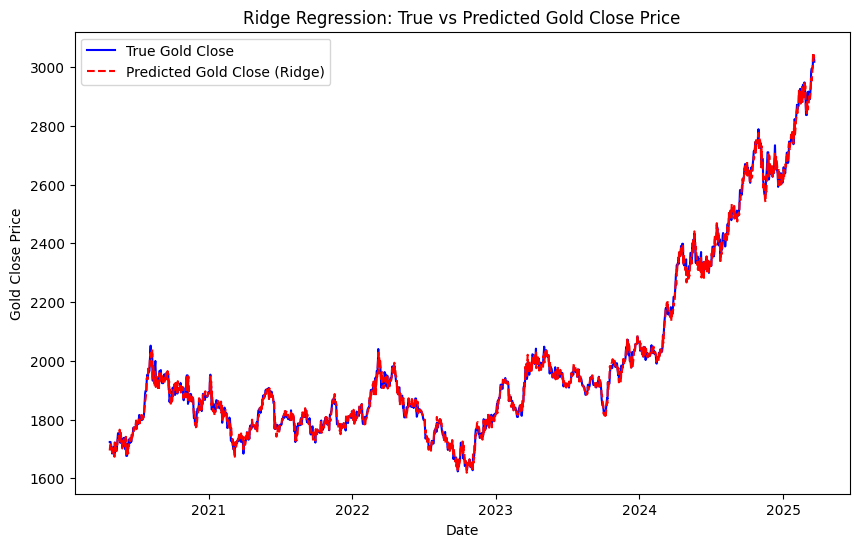

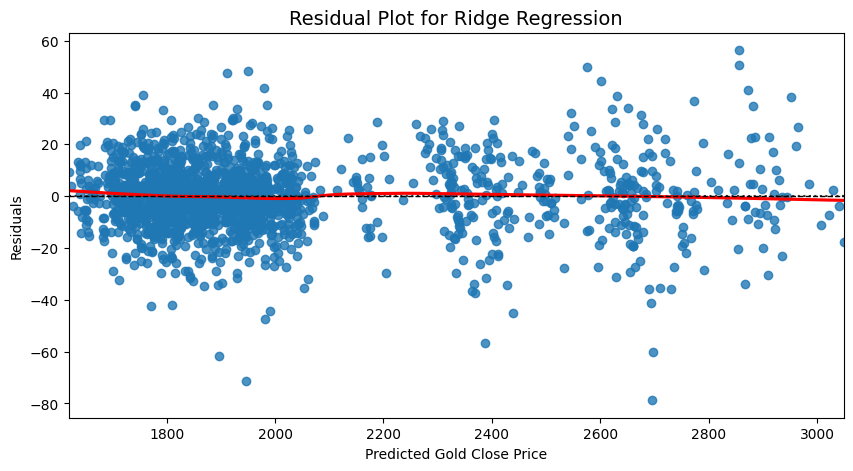

                            OLS Regression Results                            
Dep. Variable:             Gold_Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.673e+06
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:24:42   Log-Likelihood:                -33031.
No. Observations:                8968   AIC:                         6.609e+04
Df Residuals:                    8954   BIC:                         6.619e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.78

In [ ]:
# Features and target variable
features = final_data[['Interest_Rate', 'Unemployment',
                       'USD_FRANC', 'SP500_Close', 'Gold_Volume', 'Gold_Close_Change', 'Gold_Close_MA_5','Gold_Close_MA_100', 'Gold_Close_Volatility', 'RSI', 'MACD_Histogram', 'VIX', 'DXY']]
target = final_data['Gold_Close']

ridge_model = Ridge(alpha=1)

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=False)

# Store results for each fold
train_r2_scores = []
test_r2_scores = []
train_mse_scores = []
test_mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
    X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

    # Fit the model
    ridge_model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = ridge_model.predict(X_train)
    y_test_pred = ridge_model.predict(X_test)

    # Calculate performance metrics for the fold
    train_r2_scores.append(r2_score(y_train, y_train_pred))
    test_r2_scores.append(r2_score(y_test, y_test_pred))
    train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
    test_mse_scores.append(mean_squared_error(y_test, y_test_pred))

# Calculate the average metrics across all folds
avg_train_r2 = sum(train_r2_scores) / len(train_r2_scores)
avg_test_r2 = sum(test_r2_scores) / len(test_r2_scores)
avg_train_mse = sum(train_mse_scores) / len(train_mse_scores)
avg_test_mse = sum(test_mse_scores) / len(test_mse_scores)

# Print out the results
print("Ridge Regression with K-Fold Cross-Validation:")
print(f"Average Training R²: {avg_train_r2:.4f}")
print(f"Average Test R²: {avg_test_r2:.4f}")
print(f"Average Training MSE: {avg_train_mse:.4f}")
print(f"Average Test MSE: {avg_test_mse:.4f}")

# Display coefficients for last fold
coefficients = pd.DataFrame(ridge_model.coef_, features.columns, columns=['Coefficient'])
print("\nCoefficients of Ridge Regression (for the last fold):")
print(coefficients)

# Plot the predictions for the last fold
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Gold Close', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted Gold Close (Ridge)', color='red', linestyle='dashed')
plt.title('Ridge Regression: True vs Predicted Gold Close Price')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.legend()
plt.show()

# Create residuals for the last fold
residuals = y_test - y_test_pred

# Residual Plot
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title("Residual Plot for Ridge Regression", fontsize=14)
plt.xlabel("Predicted Gold Close Price")
plt.ylabel("Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

# Add a constant (intercept) to the features for OLS regression
X = sm.add_constant(features)  # Add constant (intercept) to the model
y = target

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Get the summary of the model, which includes the p-values for each feature
print(ols_model.summary())

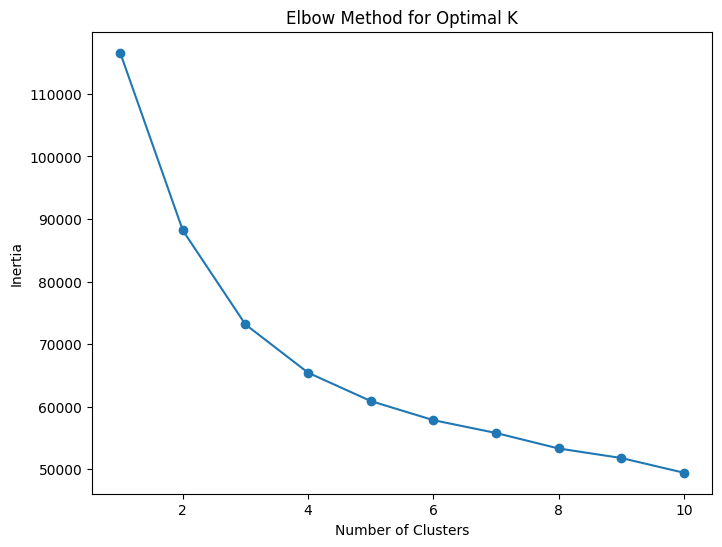

In [ ]:
# Select relevant features for clustering
features = final_data[['Interest_Rate', 'Unemployment',
                       'USD_FRANC', 'SP500_Close', 'Gold_Volume', 'Gold_Close_Change', 'Gold_Close_MA_5','Gold_Close_MA_100', 'Gold_Close_Volatility', 'RSI', 'MACD_Histogram', 'VIX', "DXY"]]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method to find optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia to identify the elbow point
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(features_scaled)

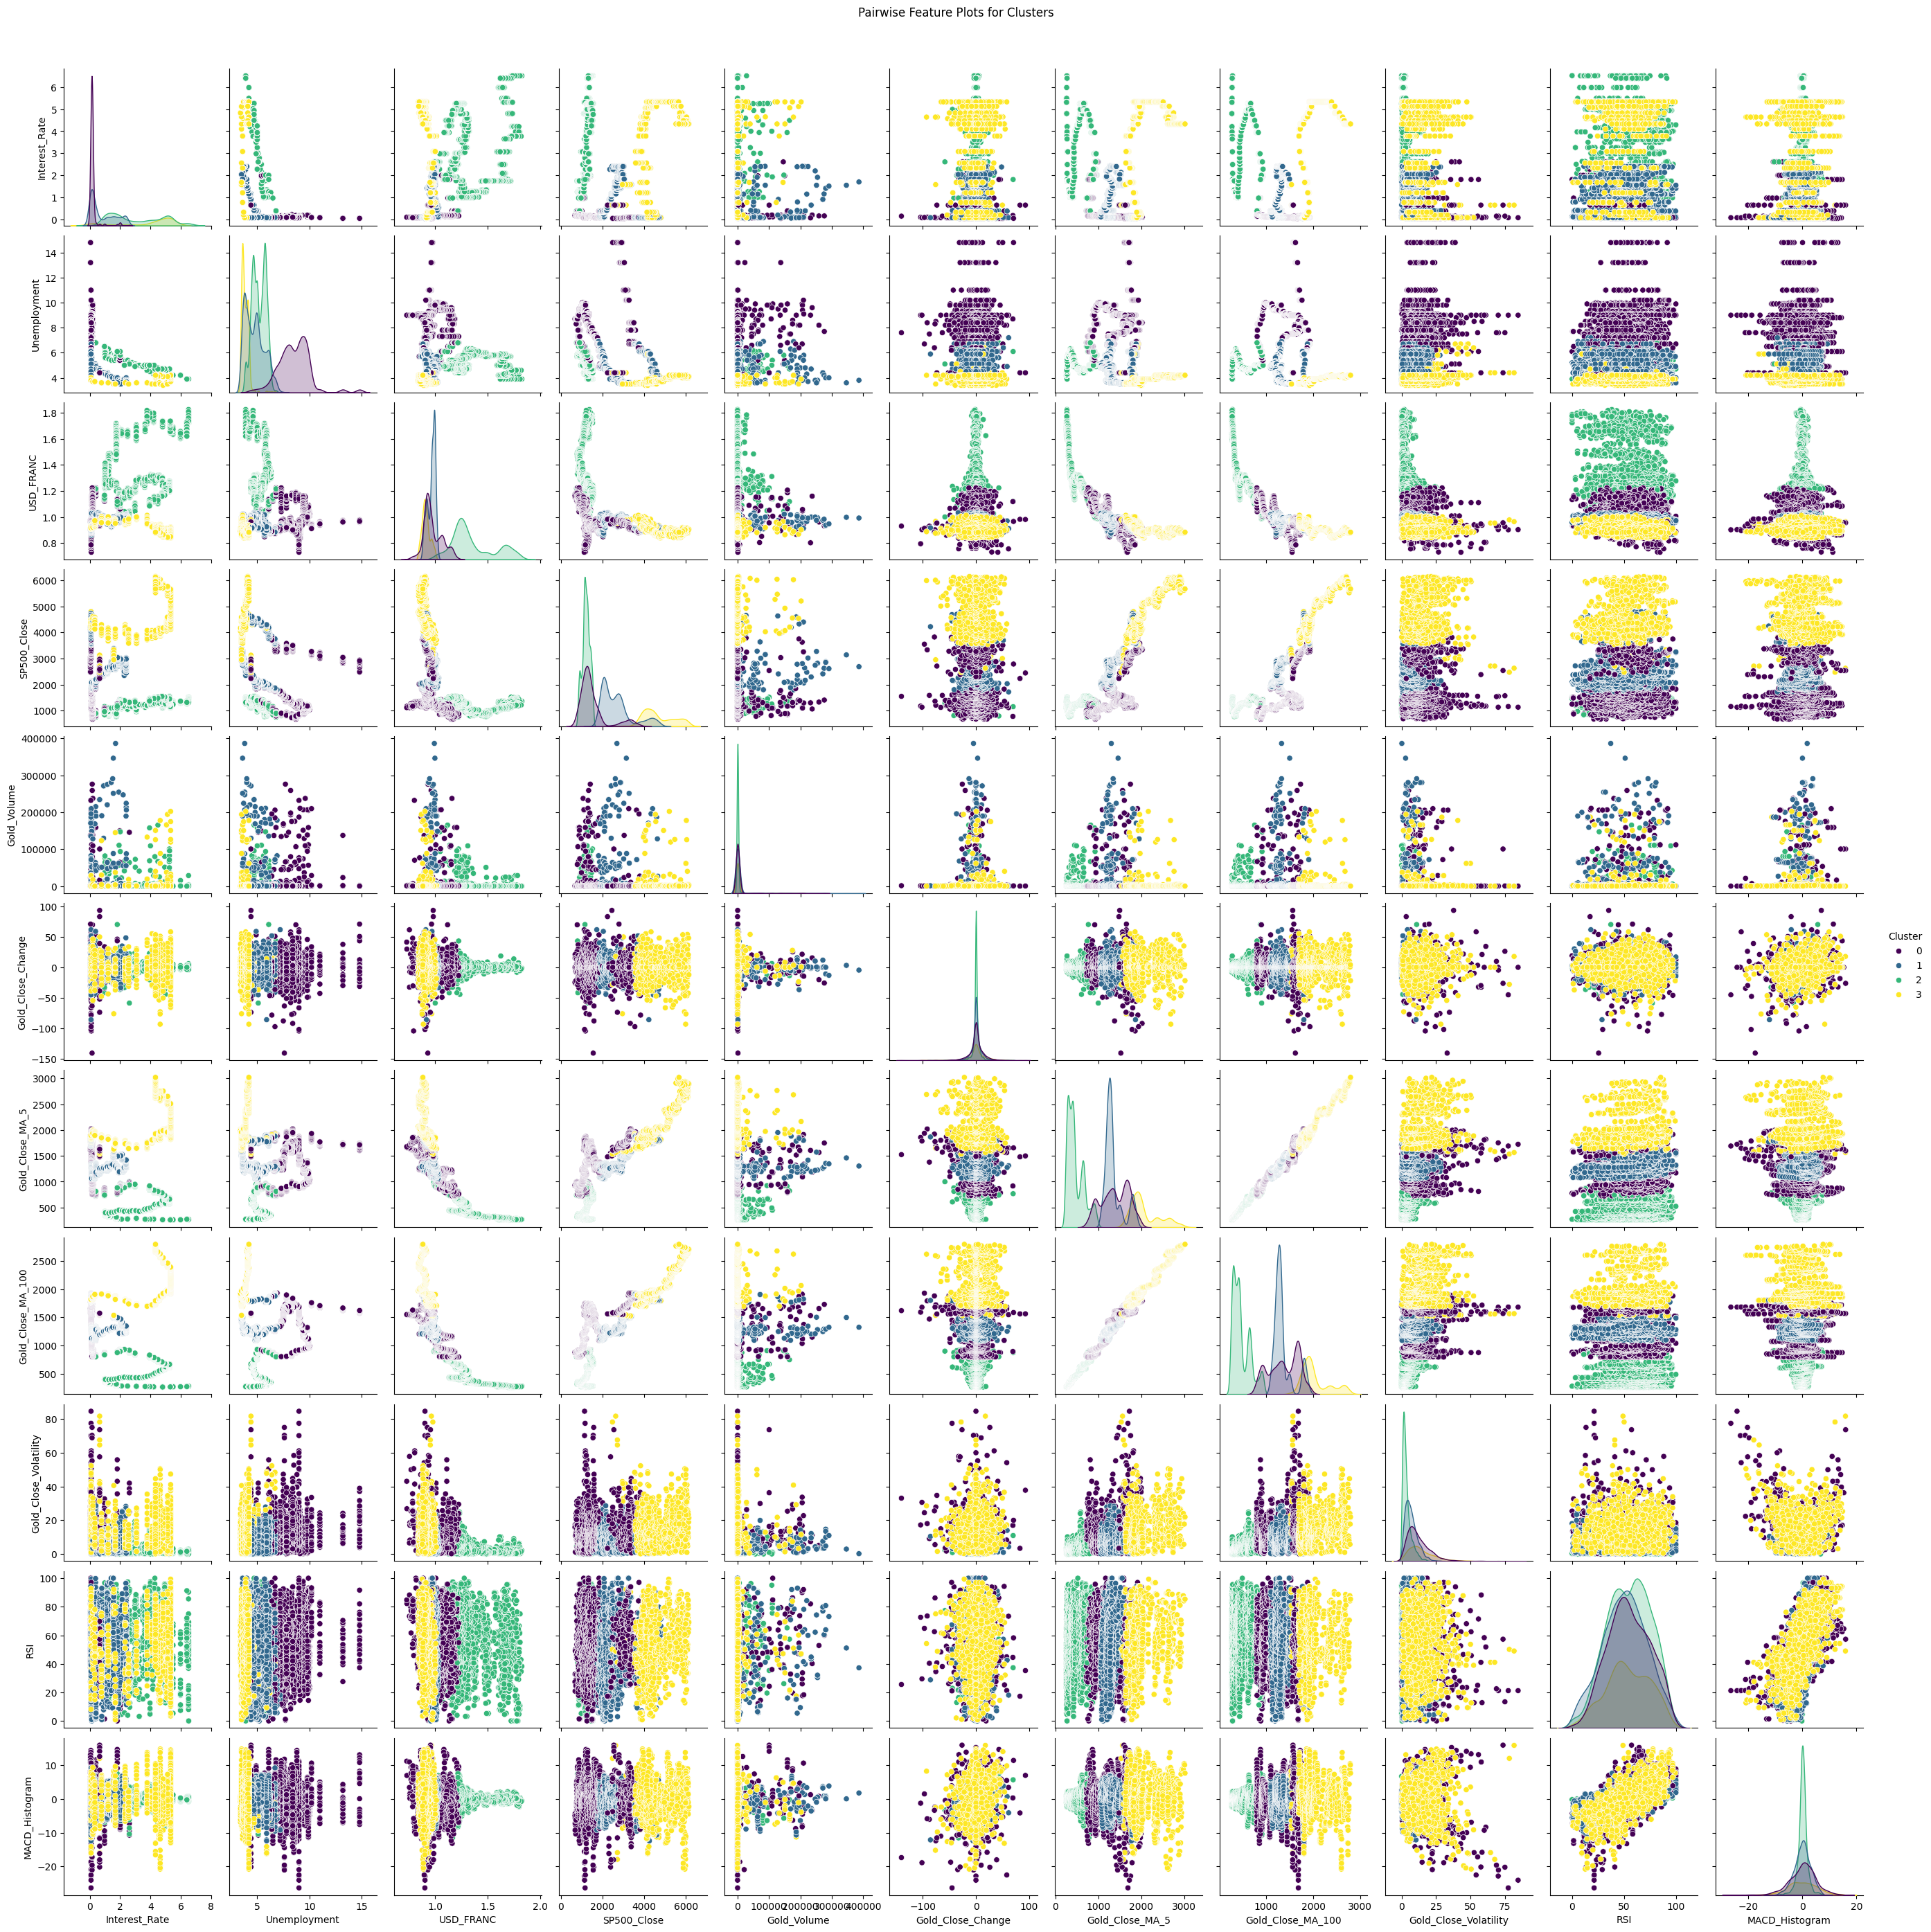

In [ ]:
# Visualizing all pairs of features with the clusters
sns.pairplot(final_data[['Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close', 'Gold_Volume',
                          'Gold_Close_Change', 'Gold_Close_MA_5', 'Gold_Close_MA_100', 'Gold_Close_Volatility',
                          'RSI', 'MACD_Histogram', 'Cluster']], hue='Cluster', palette='viridis', diag_kind='kde', markers='o')

plt.suptitle('Pairwise Feature Plots for Clusters', y=1.02)
plt.show()

In [ ]:
# Group by 'Cluster' and calculate the mean of each feature
cluster_means = final_data.groupby('Cluster')[['Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close', 'Gold_Volume',
                                              'Gold_Close_Change', 'Gold_Close_MA_5', 'Gold_Close_MA_100', 'Gold_Close_Volatility',
                                              'RSI', 'MACD_Histogram', 'VIX', 'DXY']].mean()

# Display the average values for each feature for each cluster
print("Average values for each feature by cluster:")
print(cluster_means)


Average values for each feature by cluster:
         Interest_Rate  Unemployment  USD_FRANC  SP500_Close  Gold_Volume  \
Cluster                                                                     
0             0.195752      8.506914   0.976151  1512.722820  5210.333621   
1             0.851418      4.744079   0.963959  2665.553505  5955.468911   
2             3.123556      5.162552   1.354425  1200.653715  2016.488308   
3             3.851867      3.838084   0.911493  4656.699317  3610.965602   

         Gold_Close_Change  Gold_Close_MA_5  Gold_Close_MA_100  \
Cluster                                                          
0                 0.215212      1387.137381        1369.884855   
1                 0.177148      1347.221212        1345.570435   
2                 0.173281       470.653129         461.378525   
3                 1.060770      2081.788893        2039.864448   

         Gold_Close_Volatility        RSI  MACD_Histogram        VIX  \
Cluster                 

Fold 1 - MSE: 75537.47, R²: -1.76
Fold 2 - MSE: 232594.56, R²: -1.46
Fold 3 - MSE: 2889.65, R²: 0.84
Fold 4 - MSE: 2330.88, R²: 0.96
Fold 5 - MSE: 116638.69, R²: -0.06

Average MSE: 85998.25
Average R²: -0.30


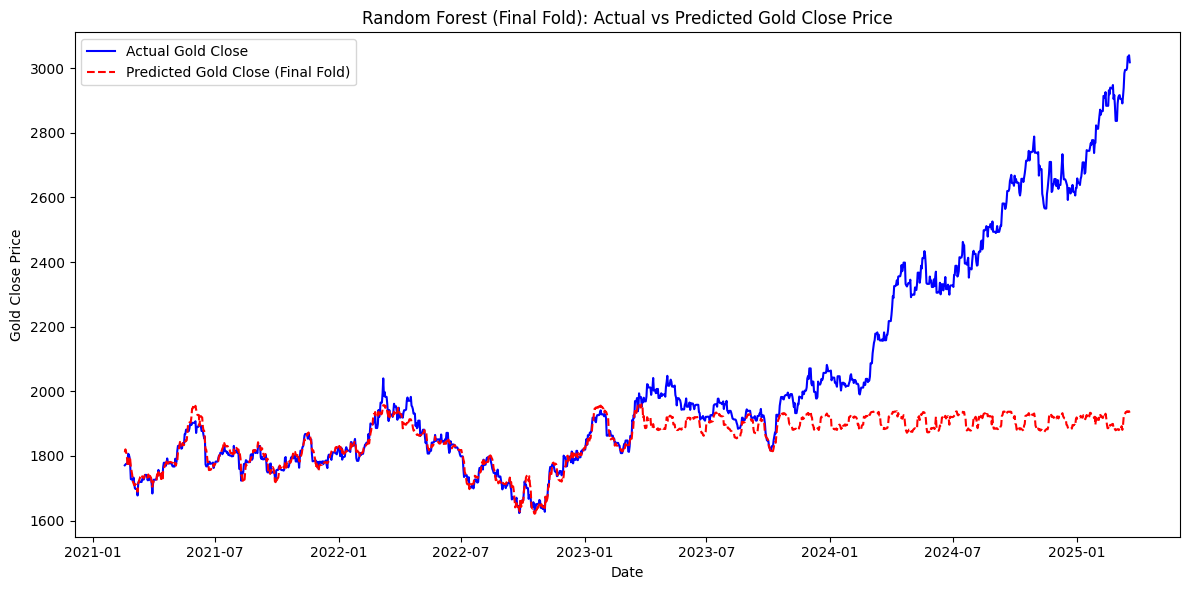

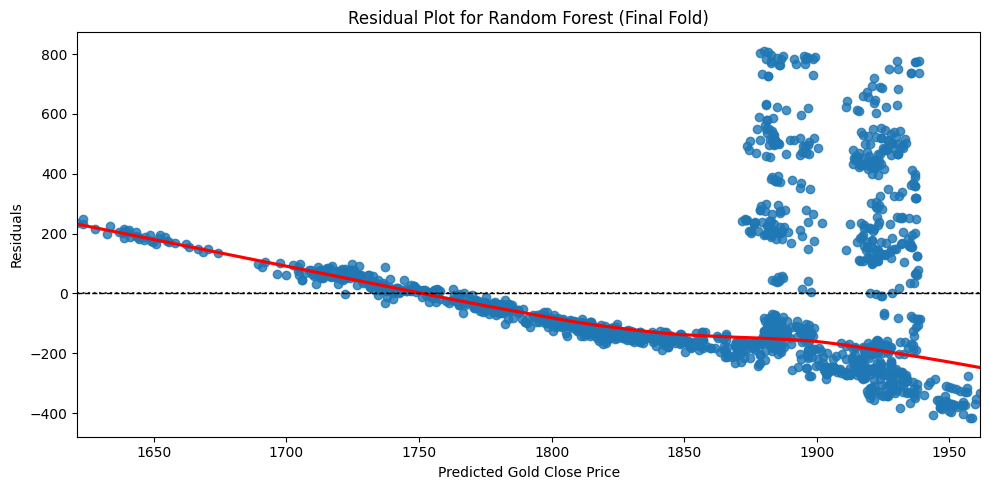

In [ ]:
# Define features and target
feature_cols = [
    'Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close',
    'Gold_Volume', 'Gold_Close_Change', 'Gold_Close_MA_5',
    'Gold_Close_MA_100', 'Gold_Close_Volatility', 'RSI', 'MACD_Histogram', "VIX", 'DXY'
]
X = final_data[feature_cols]
y = final_data['Gold_Close']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
r2_scores = []

# For plotting the final fold predictions
final_fold_idx = None
final_y_test = None
final_y_pred = None

for fold, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold + 1} - MSE: {mse:.2f}, R²: {r2:.2f}")

    if fold == tscv.get_n_splits() - 1:
        final_fold_idx = test_index
        final_y_test = y_test
        final_y_pred = y_pred

# Average metrics
print(f"\nAverage MSE: {np.mean(mse_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.2f}")

# Plot predictions vs actuals for final fold
plt.figure(figsize=(12, 6))
plt.plot(final_y_test.index, final_y_test, label='Actual Gold Close', color='blue')
plt.plot(final_y_test.index, final_y_pred, label='Predicted Gold Close (Final Fold)', color='red', linestyle='--')
plt.title('Random Forest (Final Fold): Actual vs Predicted Gold Close Price')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Residuals for final fold
residuals = final_y_test - final_y_pred
plt.figure(figsize=(10, 5))
sns.residplot(x=final_y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot for Random Forest (Final Fold)')
plt.xlabel('Predicted Gold Close Price')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2644 - val_loss: 0.5626
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1165 - val_loss: 0.2852
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0896 - val_loss: 0.1709
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0748 - val_loss: 0.1140
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0637 - val_loss: 0.1033
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0568 - val_loss: 0.0857
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0493 - val_loss: 0.0909
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0426 - val_loss: 0.0417
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.0495
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0361
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321 - val_loss: 0.0190
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

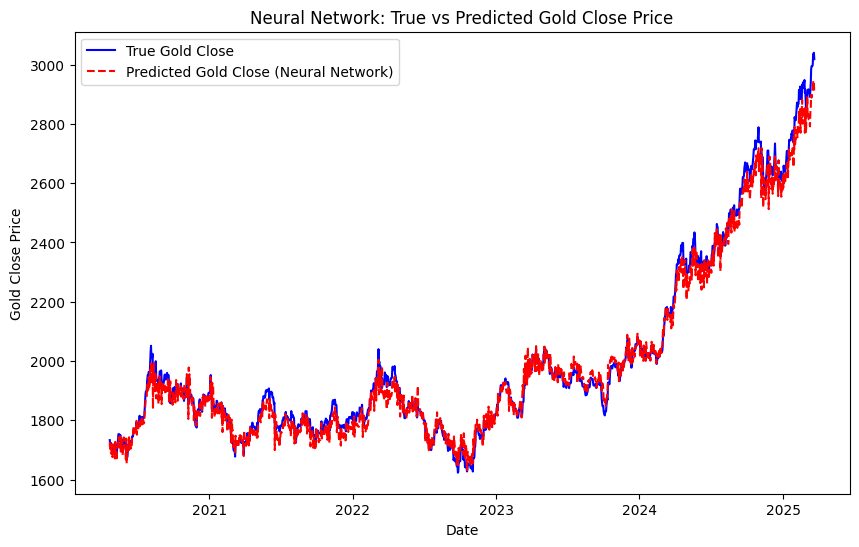

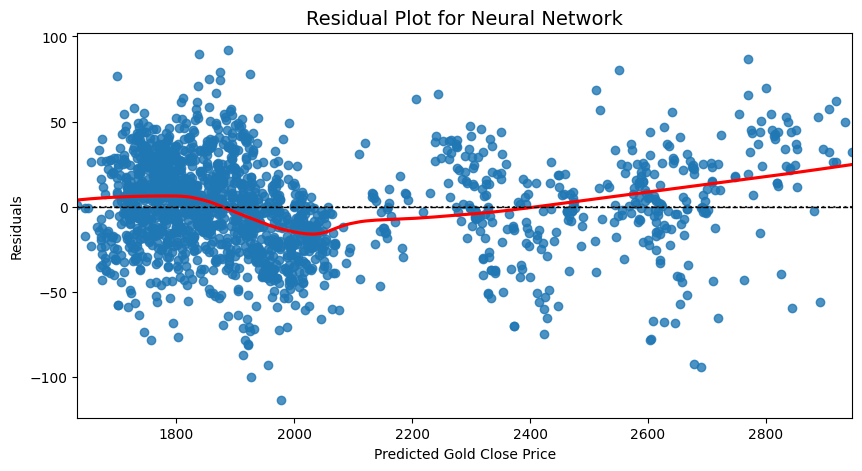

In [ ]:
# Features and target variable
features = final_data[['Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close', 'Gold_Volume',
                       'Gold_Close_Change', 'Gold_Close_MA_5', 'Gold_Close_MA_100', 'Gold_Close_Volatility',
                       'RSI', 'MACD_Histogram', 'VIX', 'DXY']]
target = final_data['Gold_Close']

# Standardize the features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(features)

# Standardize the target variable
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_scaled, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test_scaled),
                    callbacks=[early_stop])

# Predict (scaled)
y_train_pred_scaled = model.predict(X_train).flatten()
y_test_pred_scaled = model.predict(X_test).flatten()

# Inverse-transform predictions and targets
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train_actual = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test_actual = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate performance metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print performance
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Plot true vs predicted gold close prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test_actual, label='True Gold Close', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted Gold Close (Neural Network)', color='red', linestyle='dashed')
plt.title('Neural Network: True vs Predicted Gold Close Price')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.legend()
plt.show()

# Residual Plot
residuals = y_test_actual - y_test_pred
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title("Residual Plot for Neural Network", fontsize=14)
plt.xlabel("Predicted Gold Close Price")
plt.ylabel("Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()